# Healthy haematopoiesis scATAC-seq data preprocessing
In this notebook we process the scATAC-seq data from the scATAC-seq Hematopoeisis cell x peak Summarized Experiment data belonging to the Granja et al. (2019) paper as downloaded from https://jeffgranja.s3.amazonaws.com/MPAL-10x/Supplementary_Data/Healthy-Data/scATAC-Healthy-Hematopoiesis-191120.rds To run this notebook, please make sure to download this data and put it into a subfolder called raw in a data folder that is in the same directory as your notebook directory. Then, process the data using 2_scATAC_rds_to_mtx.R and 3_rbarcodes_rgenees_rpeaks_to_pylist.py ../../scripts/

## 1. Set up the notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.io import mmread, mmwrite
from SEMITONES.tfidf import TFIDF
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import scale

Set working directory as the interim folder in which we can change data.

In [2]:
os.chdir("../data/interim/")

Create a colormap.

In [3]:
persianorange = "#d99058"
cplblue2 = "#374350"
chesnut = "#cd5c5c"
rosequartz = "#aa98a9"
oldmauve = "#673147"
oldrose = "#c08081"
antiquefuchsia = "#915c83"
oldlavender = "#796878"
pastelblue = "#aec6cf"
babyblue = "#a1caf1"
glaucous = "#6082b6"
cambridge = "#a3c1ad"
asparagus = "#87a96b"
greyasparagus = "#465945"
arylide = "#e9dc9f"
oldgold = "#d6bf4c"
orangeyellow = "#e5a327"
brass = "#b5a642"
olive = "#808000"
clpblue = "#3e4b59"
lavender = "#e6e6fa"
teal = "#469990"
pink = "#fabebe"
brown = "#a52a2a"
khaki = "#c3b091"
orange = "#e59400"

colors = [khaki, chesnut, brown, orange, arylide, clpblue, persianorange,
          orangeyellow, asparagus, teal, olive, brass, oldgold, greyasparagus,
          cplblue2, glaucous, babyblue, pastelblue, oldmauve, oldlavender,
          antiquefuchsia, rosequartz, oldrose, pink, lavender, greyasparagus]

## 2. Load data
We load the data in ".mtx" format and read in the barcodes and peak names

In [4]:
class scdata(object):
    def __init__(self, name=None, counts=None):
        self.name = name
        self.counts = counts

In [5]:
data = {}
data["combined"] = scdata(name="combined",
                          counts=mmread("greenleaf_scATAC_combined.mtx"))
data["combined"].counts = data["combined"].counts.tocsr()
data["combined"].barcodes = []
with open("greenleaf_scATAC_combined_barcodes.txt", "r") as f:
    data["combined"].barcodes.extend([l.strip("\n") for l in f.readlines()])
f.close()
data["combined"].peaks = []
with open("greenleaf_scATAC_combined_peaks.txt", "r") as f:
    data["combined"].peaks.extend([l.strip("\n") for l in f.readlines()])
f.close()

## 2. Filtering

Despite pervious filtering of the data in the SummarizedExperiment, we filter out cells with outlier numbers of counts per cell or peaks called per cell.

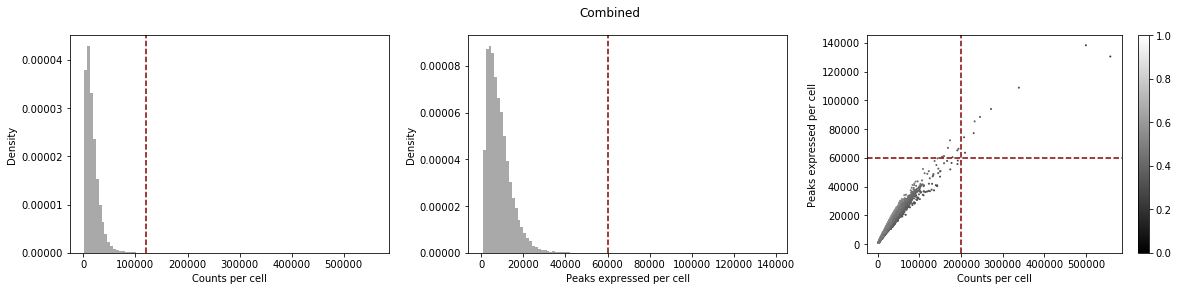

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(20)
fig.subplots_adjust(wspace=0.25)
fig.suptitle("Combined")

data["combined"].count_depth = np.array(data["combined"].counts.sum(axis=1)).ravel()
ax1.hist(data["combined"].count_depth, bins=100, color="darkgrey", density=True)
ax1.axvline(120000, color="maroon", ls="--")
ax1.set_ylabel("Density")
ax1.set_xlabel("Counts per cell")

data["combined"].npeaks_det = data["combined"].counts.getnnz(axis=1)
ax2.hist(data["combined"].npeaks_det, bins=100, color="darkgrey", density=True)
ax2.axvline(60000, color="maroon", ls="--")
ax2.set_ylabel("Density")
ax2.set_xlabel("Peaks expressed per cell")

ratio = data["combined"].npeaks_det / data["combined"].count_depth
_ = ax3.scatter(x=data["combined"].count_depth, y=data["combined"].npeaks_det, c=ratio,
                cmap="gray", vmin=0, vmax=1, s=1)
ax3.set_ylabel("Peaks expressed per cell")
ax3.set_xlabel("Counts per cell")
ax3.axvline(200000, color="maroon", ls="--")
ax3.axhline(60000, color="maroon", ls="--")
fig.colorbar(_)

plt.show()

We remove cells with more than 2,000,000 counts per cell and more than 60,000 individual peaks detected per cell.

In [7]:
idxs = list(set(np.where(data["combined"].count_depth < 200000)[0]
               ).intersection(
            set(np.where(data["combined"].npeaks_det < 60000)[0])))
data["combined"].filtered = data["combined"].counts[idxs, :]
data["combined"].f_barcodes = np.array(data["combined"].barcodes)[idxs]

We also filter out peaks with very high numbers of reads

In [8]:
data["combined"].peak_depth = data["combined"].filtered.sum(axis=0)
data["combined"].peak_depth = np.array(data["combined"].peak_depth)[0]

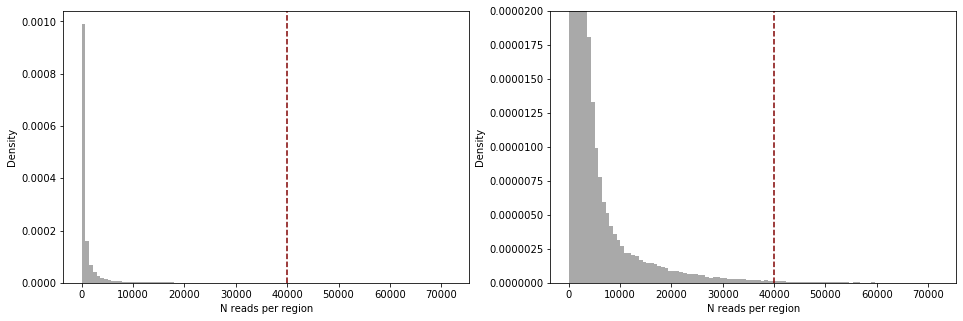

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(16)

ax1.hist(data["combined"].peak_depth, bins=100, color="darkgrey", density=True)
ax1.set_ylabel("Density")
ax1.set_xlabel("N reads per region")

ax2.hist(data["combined"].peak_depth, bins=100, color="darkgrey", density=True)
ax2.set_ylabel("Density")
ax2.set_xlabel("N reads per region")
ax2.set_ylim(0, .00002)

for ax in [ax1, ax2]:
    ax.axvline(40000, color="maroon", ls="--")

Remove peaks that have more than 40000 reads on average.

In [10]:
idxs = np.where(data["combined"].peak_depth < 40000)[0]
data["combined"].filtered = data["combined"].filtered[:, idxs]
data["combined"].f_peaks = np.array(data["combined"].peaks)[idxs]

We now save the data, with the filtered barcodes into the processed data folder

In [11]:
mmwrite("../processed/greenleaf_scATAC_peaks_filtered.mtx", data["combined"].filtered)
with open("../processed/greenleaf_scATAC_filtered_barcodes.txt", "w") as f:
    for b in data["combined"].f_barcodes:
        f.write("{0}\n".format(b))
f.close()
with open("../processed/greenleaf_scATAC_peaks_filtered.txt", "w") as f:
    for p in data["combined"].f_peaks:
        f.write("{0}\n".format(p))
f.close()

## 2. Dimensionality reduction

Binarize the count matrix

In [12]:
def binarize(X, t):
    X = X.copy()
    condition = X.data >= t
    X.data[condition] = 1
    X.data[np.logical_not(condition)] = 0
    return X

In [13]:
data["combined"].binarized = binarize(data["combined"].filtered, 1)

Latent Semantic Indexing

In [14]:
data["combined"].tfidf = TFIDF(data["combined"].binarized)

In [15]:
mmwrite("greenleaf_scATAC_filtered_tfidf.mtx", data["combined"].tfidf)

In [16]:
data["combined"].svd = TruncatedSVD(n_components=50
                                   ).fit_transform(data["combined"].tfidf)

In [17]:
mmwrite("../processed/greenleaf_scATAC_filtered_svd50.mtx", data["combined"].svd)

Create a 2D UMAP for visualization

In [18]:
data["combined"].umap = UMAP(n_components=2, n_neighbors=50,
                             min_dist=0.5, random_state=42
                            ).fit_transform(data["combined"].svd[:, 0:50])

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

In [19]:
np.save("../processed/greenleaf_scATAC_filtered_umap.npy", data["combined"].umap)

We visualize the data with the previously published labels as a guidance

In [20]:
# load the labels from the original data publication
metadata = pd.read_csv("../external/greenleaf_scATAC_cell_metadata.txt",
                       sep="\t")

# create a color code for the biological labels
bio_labels = metadata.loc[data["combined"].f_barcodes
                     ].BioClassification.values
bio_coldict = dict(zip(np.unique(bio_labels), colors))
bio_color = bio_labels
for l, c in bio_coldict.items():
    bio_color = [c if i == l else i for i in bio_color]
bio_legend = {k: bio_coldict[k] for k in np.unique(bio_labels)}
bio_marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
              for c in bio_legend.values()]

# create a color code for the sample labels
smp_labels = metadata.loc[data["combined"].f_barcodes
                     ].Group.values
smp_labels = [g.split("_")[0] for g in smp_labels]
smp_coldict = dict(zip(np.unique(smp_labels), colors))
smp_color = smp_labels
for l, c in smp_coldict.items():
    smp_color = [c if i == l else i for i in smp_color]
smp_legend = {k: smp_coldict[k] for k in np.unique(smp_labels)}
smp_marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
              for c in smp_legend.values()]

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


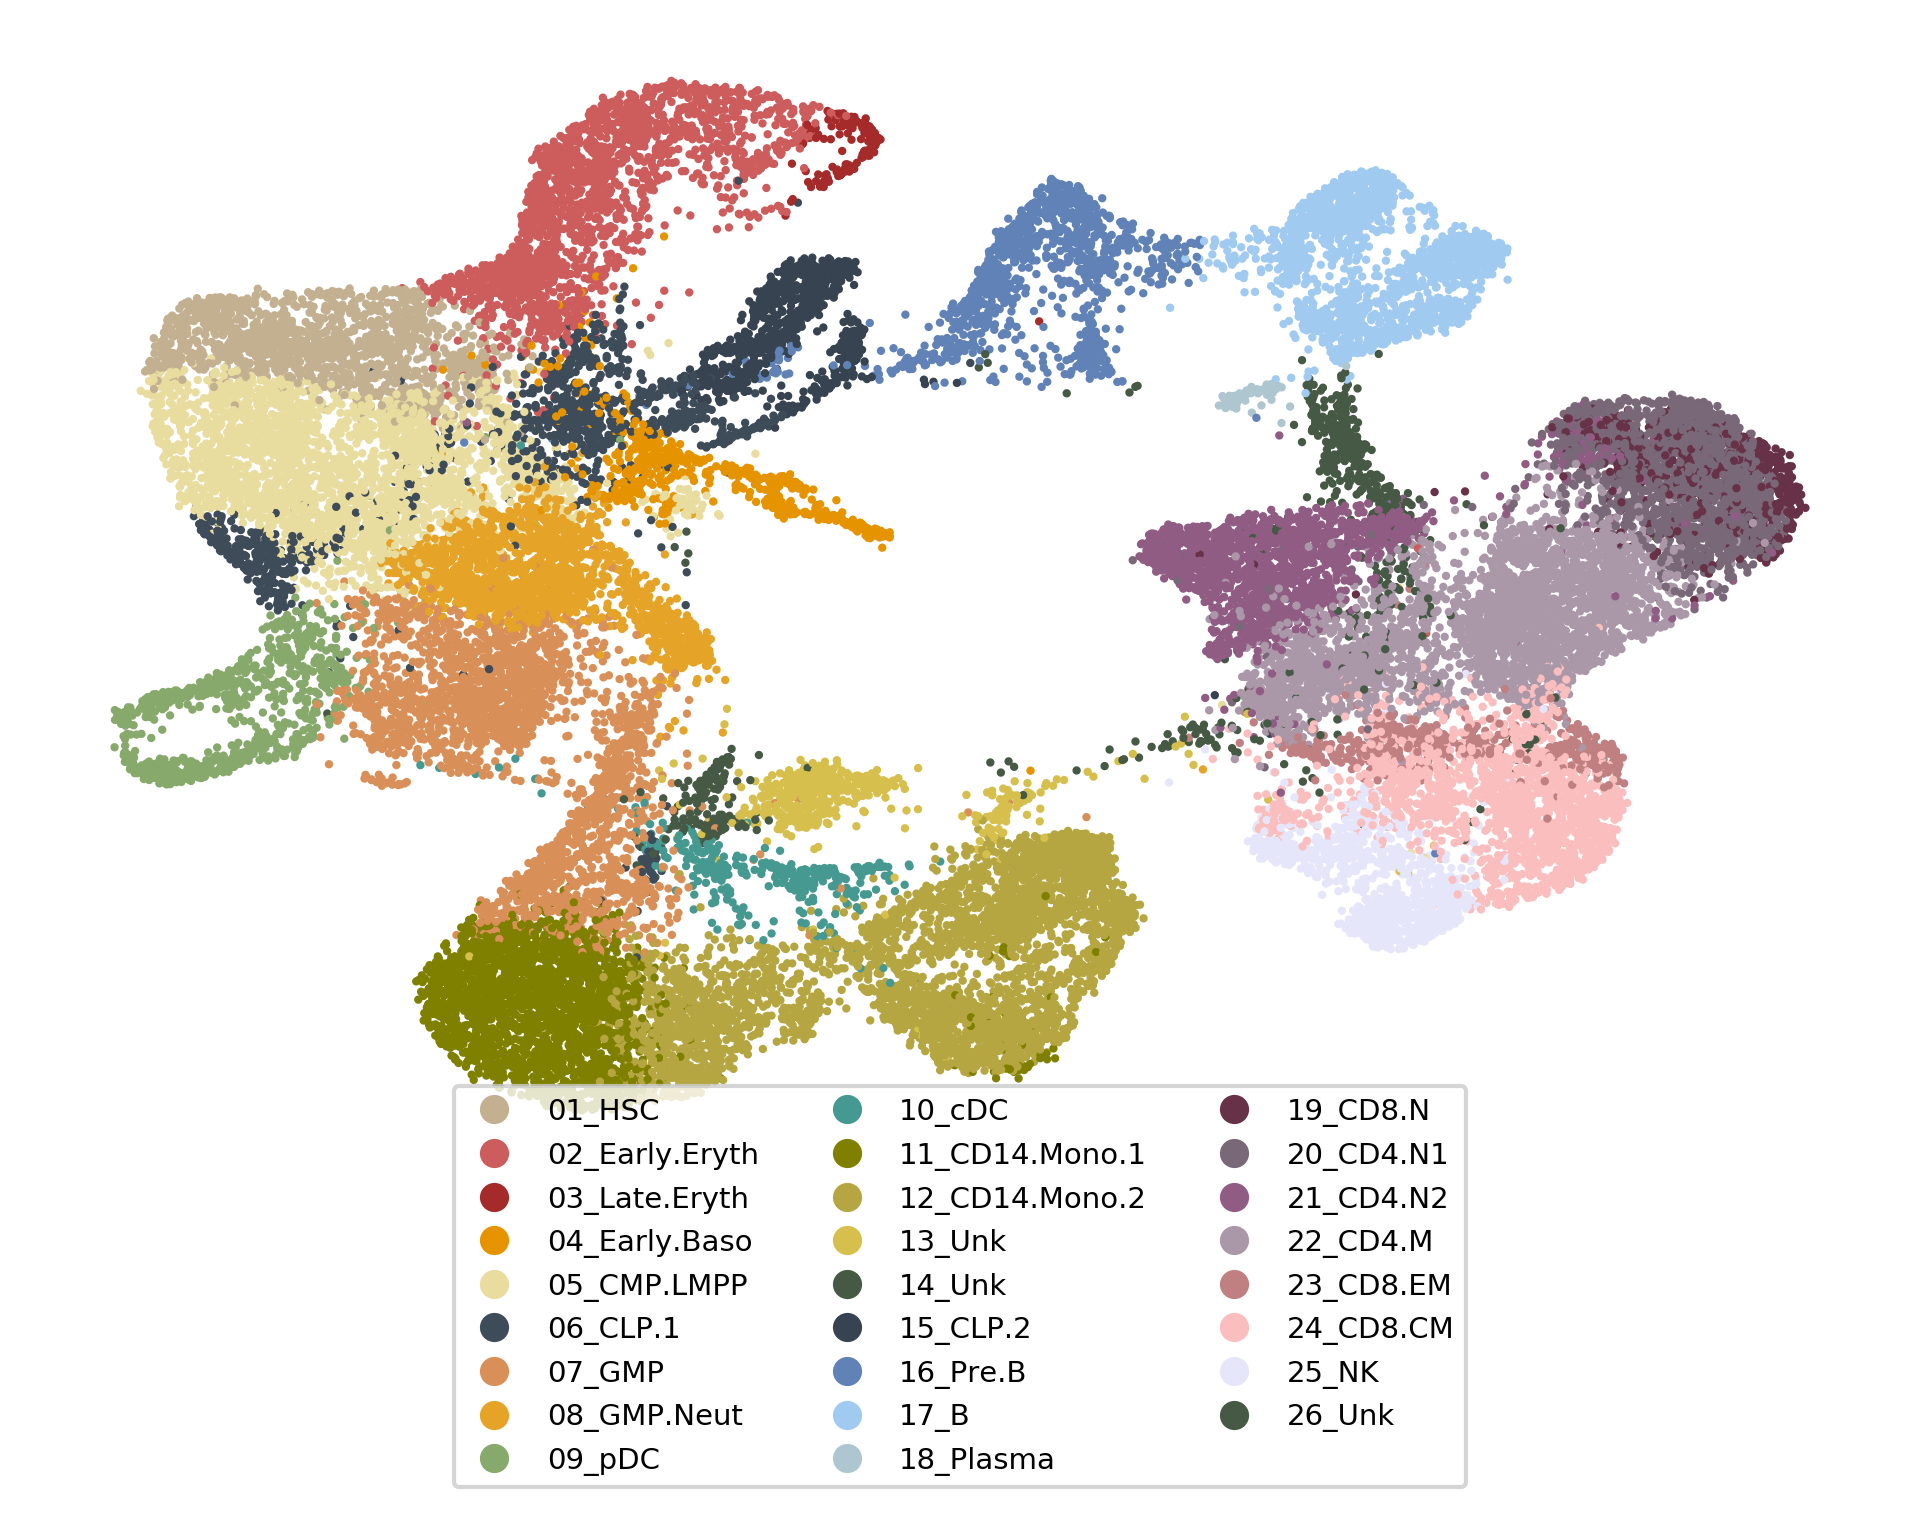

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


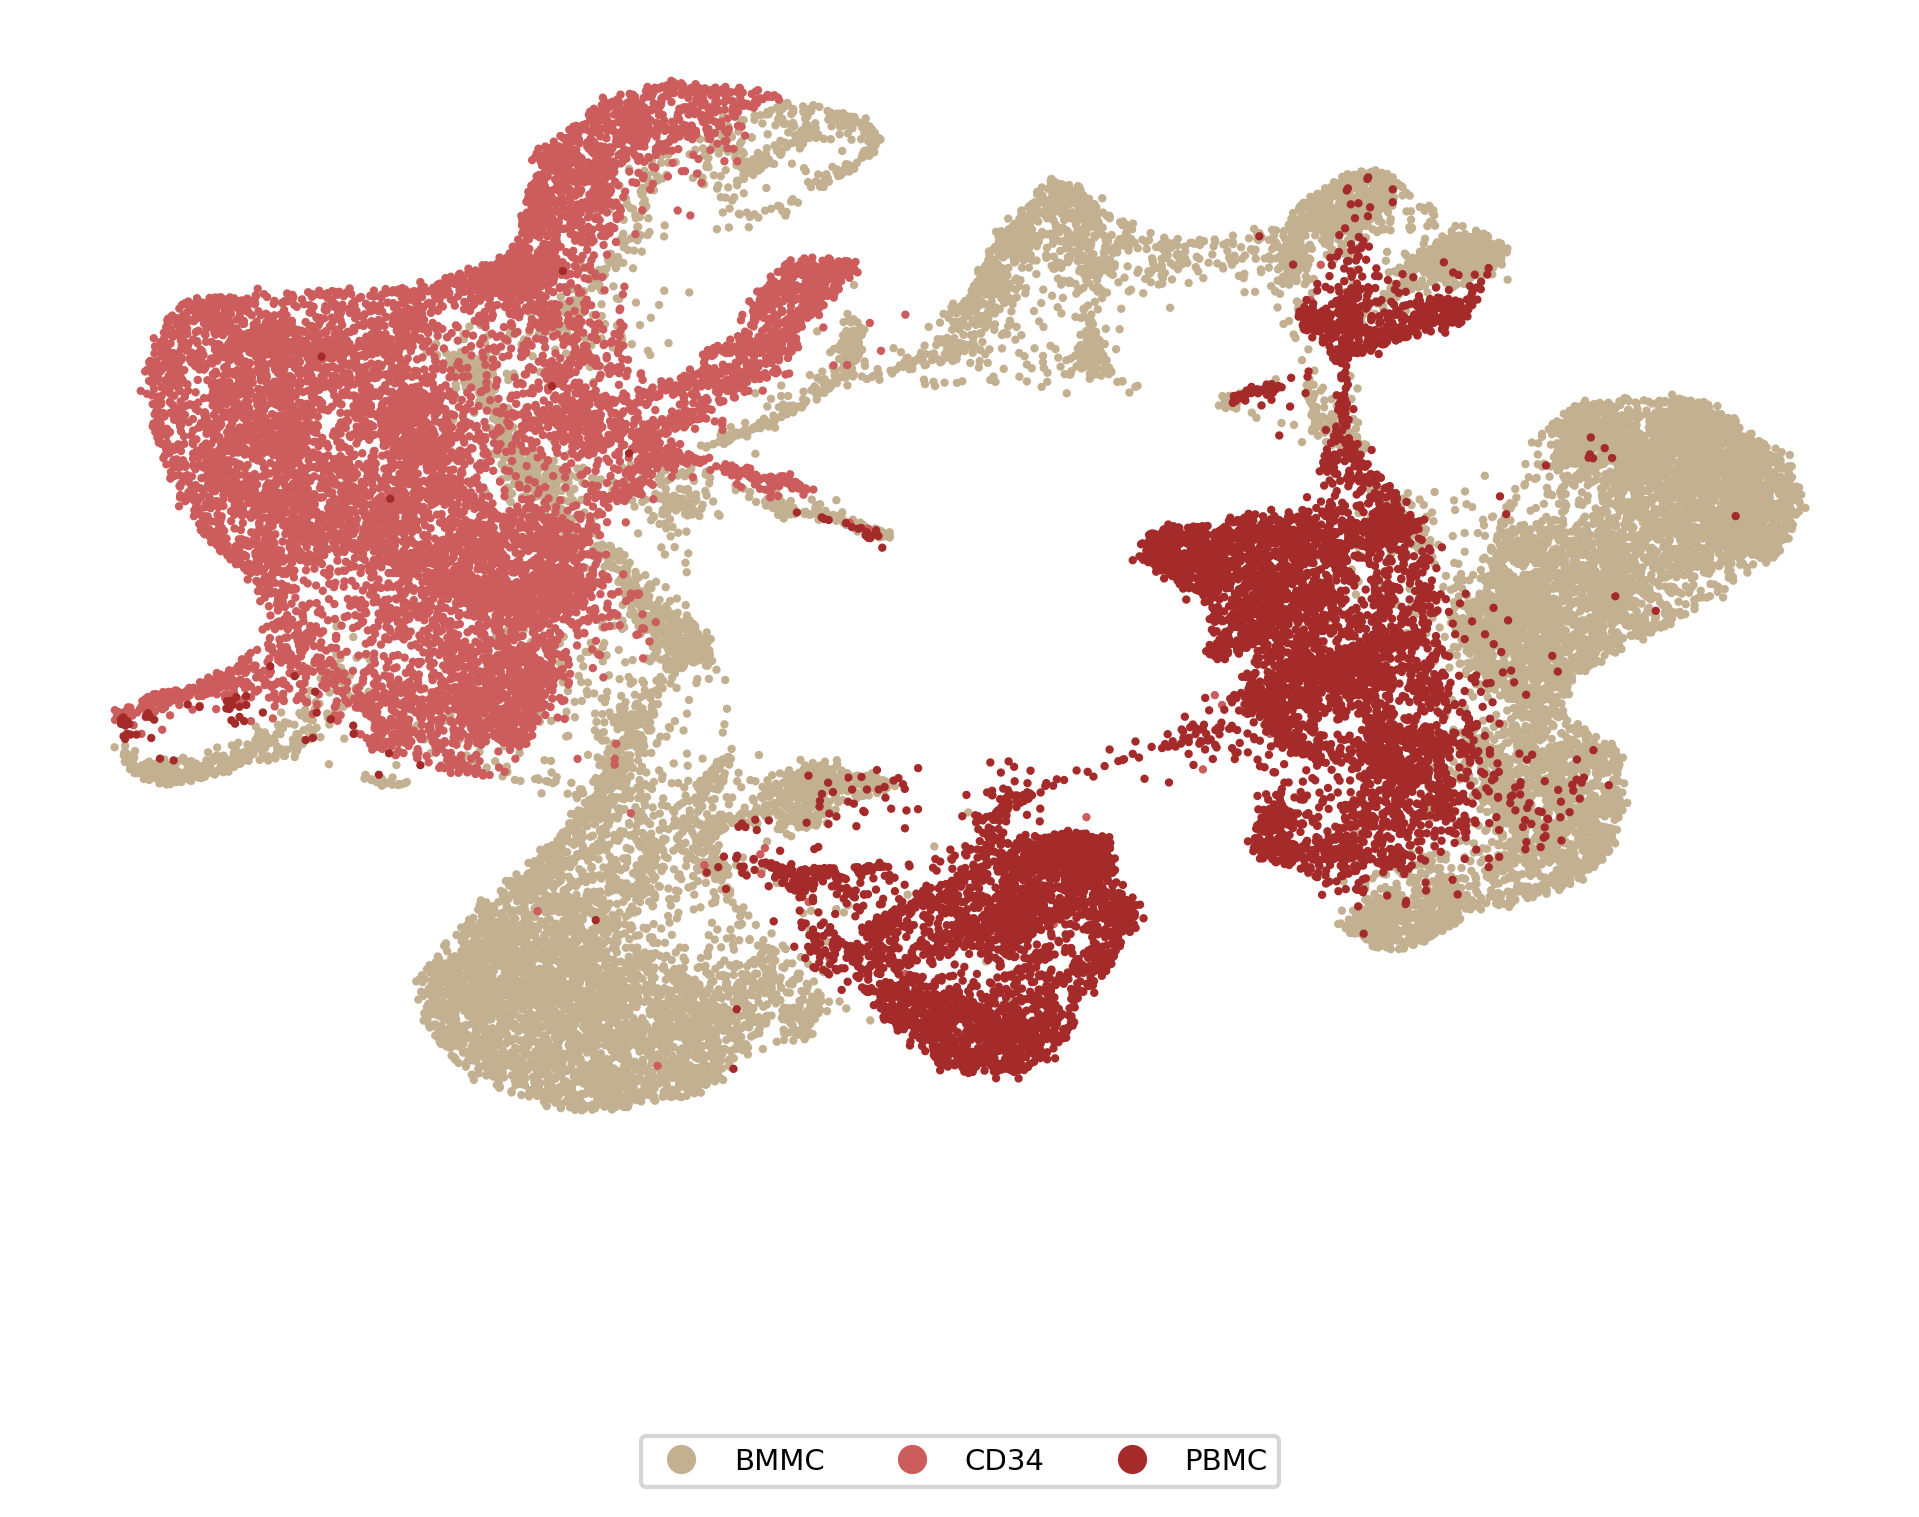

In [21]:
# plot the UMAP with labels
plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(x=data["combined"].umap[:, 0], y=data["combined"].umap[:, 1],
            s=1, c=bio_color)
plt.legend(bio_marker, bio_legend.keys(), numpoints=0.2, fontsize=7, ncol=3,
           loc="lower center", bbox_to_anchor=(0.5, -0.3))

ax = plt.axes()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

plt.show()

plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(x=data["combined"].umap[:, 0], y=data["combined"].umap[:, 1],
            s=1, c=smp_color)
plt.legend(smp_marker, smp_legend.keys(), numpoints=0.2, fontsize=7, ncol=3,
           loc="lower center", bbox_to_anchor=(0.5, -0.3))

ax = plt.axes()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

plt.show()

We also create and save a 35D UMAP

In [22]:
data["combined"].umap = UMAP(n_components=35, n_neighbors=50,
                             min_dist=0.5, random_state=42
                            ).fit_transform(data["combined"].svd[:, 0:50])

/home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../home/hvlot/miniconda3/envs/hcv1/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [23]:
np.save("../processed/greenleaf_scATAC_filtered_umap35.npy", data["combined"].umap)